# **Getting Started**

Welcome to Segmind. This JupyterLab interface is the next-generation of notebook interface that supports a wide range of workflows in data science, scientific computing, and machine learning. If you are new to notebooks, we recommend you to look at JupyterLab's official [documentation](https://jupyterlab.readthedocs.io/en/latest/user/interface.html).
Kick-start your project with Segmind without worrying about the environment setup.

# Sample project (Deep Learing)
To help you explore Segmind's Juno platform, we have put together this sample notebook to take you through the major features Segmind offers.


### Select the instance type you require for your project. 
You can change the instance type any time in between. Thus, you could use CPU instance for preparation of your code and switch to GPU instance for training of your networks. 

Note - Each time you change the instance the kernel will restart, resulting in loss of all the variables in the memory.

## MNIST Classification Example
We will build a simple fully connected convolutional neural network (a.k.a multilayer perceptron) with TensorFlow 1.15.

## Download Mnist Data

In [1]:
!mkdir dataset
!wget https://segmind-data.s3.ap-south-1.amazonaws.com/mnist_data.zip -P dataset
!unzip dataset/mnist_data.zip -d dataset/

mkdir: cannot create directory ‘dataset’: File exists
--2021-03-19 15:51:01--  https://segmind-data.s3.ap-south-1.amazonaws.com/mnist_data.zip
Resolving segmind-data.s3.ap-south-1.amazonaws.com (segmind-data.s3.ap-south-1.amazonaws.com)... 52.219.66.23
Connecting to segmind-data.s3.ap-south-1.amazonaws.com (segmind-data.s3.ap-south-1.amazonaws.com)|52.219.66.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39260719 (37M) [application/zip]
Saving to: ‘dataset/mnist_data.zip.1’

mnist_data.zip.1    100%[===================>]  37.44M  8.30MB/s    in 5.6s    

2021-03-19 15:51:08 (6.73 MB/s) - ‘dataset/mnist_data.zip.1’ saved [39260719/39260719]

Archive:  dataset/mnist_data.zip
replace dataset/mnist_data/train/5/5_100.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Import Libraries

In [2]:
import os
import numpy as np
import cv2
import keras
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

Using TensorFlow backend.


In [3]:
## Set data path
img_folder_path = 'dataset/mnist_data/'

## Load Train Data

In [4]:
train_X = []
train_y = []

mode = 'train'
classes = os.listdir(os.path.join(img_folder_path, mode))
for cl in classes:
    files = os.listdir(os.path.join(img_folder_path, mode, cl))
    for f in files:
        image_path= os.path.join(img_folder_path, mode, cl, f)
        img=cv2.imread(image_path,0)
        train_X.append(img)
        train_y.append(cl)
        
train_X = np.asarray(train_X)
train_y = np.asarray(train_y)

## Load Test Data

In [5]:
test_X = []
test_y = []

mode = 'test'
classes = os.listdir(os.path.join(img_folder_path, mode))
for cl in classes:
    files = os.listdir(os.path.join(img_folder_path, mode, cl))
    for f in files:
        image_path= os.path.join(img_folder_path, mode, cl, f)
        img=cv2.imread(image_path,0)
        test_X.append(img)
        test_y.append(cl)

test_X = np.asarray(test_X)
test_y = np.asarray(test_y)

## Display Data

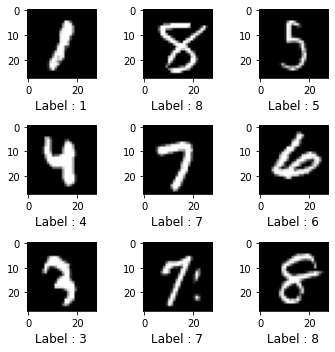

In [6]:
r_idx = np.random.randint(len(train_X),size=9)
plt.figure(figsize=(5,5))
for i,idx in enumerate(r_idx):
    plt.subplot(3,3,i+1)
    plt.imshow(train_X[idx], cmap=plt.get_cmap('gray'))
    plt.xlabel("Label : " + train_y[idx], fontsize=12)
plt.show()

## Pre-process Data

In [7]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], train_X.shape[2], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], test_X.shape[2], 1))

# convert from integers to floats
train_norm_X = train_X.astype('float32')
test_norm_X = test_X.astype('float32')
# normalize to range 0-1
train_norm_X = train_norm_X / 255.0
test_norm_X = test_norm_X / 255.0

In [8]:
#set number of categories
num_category = 10
# convert class vectors to binary class matrices
train_y = keras.utils.to_categorical(train_y, num_category)
test_y = keras.utils.to_categorical(test_y, num_category)

In [9]:
## Print processed data shape
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


## Save processed data to directory
This step is done in order to store the processed data to the directory. So, if you change the instance type you would be able to directly load and use the processed data.

In [10]:
if not os.path.exists('dataset/processed_data'):
    os.mkdir('dataset/processed_data')
    
np.save('dataset/processed_data/train_X.npy', train_norm_X)
np.save('dataset/processed_data/train_y.npy', train_y)
np.save('dataset/processed_data/test_X.npy', test_norm_X)
np.save('dataset/processed_data/test_y.npy', test_y)

## Switch the instance to GPU type
To switch the instance, click settings on top right corner of jupyter lab and select Change Machine option.

![](./imgs/switch_instance.png)

After switching the instance, as the kernel gets restarted. You do not need to run the whole notebook again, as we have already stored the processed data into the directory. You just need to load the data back and go on with the training.

In [11]:
## Import keras callbacks to track your model's live progress and performance on Segmind Track.
from segmind.keras import KerasCallback
keras_cb = KerasCallback()

In [12]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [13]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.callbacks import ModelCheckpoint
from keras import backend as k
import matplotlib.pyplot as plt
import numpy as np


### Load processed data

In [14]:
train_X = np.load('dataset/processed_data/train_X.npy')[:,:,:,0:1]
train_y = np.load('dataset/processed_data/train_y.npy')
test_X = np.load('dataset/processed_data/test_X.npy')[:,:,:,0:1]
test_y = np.load('dataset/processed_data/test_y.npy')

### Define model

In [15]:
#input image size 28*28
img_rows , img_cols = 28, 28
input_shape = (img_rows, img_cols,1)
num_category = 10

In [16]:
# Define the model
model = Sequential()
#convolutional layer with rectified linear unit activation
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
#32 convolution filters used each of size 3x3
#again
model.add(Conv2D(64, (3, 3), activation='relu'))
#64 convolution filters used each of size 3x3
#choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
#randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
model.add(Flatten())
#fully connected to get all relevant data
model.add(Dense(128, activation='relu'))
#one more dropout for convergence' sake :) 
model.add(Dropout(0.5))
#output a softmax to squash the matrix into output probabilities
model.add(Dense(num_category, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [17]:
#Adaptive learning rate (adaDelta) is a popular form of gradient descent rivaled only by adam and adagrad
#categorical ce since we have multiple classes (10) 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [18]:
# Checkpoint to save the best model while training

if not os.path.exists('models'):
    os.mkdir('models')

checkpoint = ModelCheckpoint('models/best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [19]:
batch_size = 16
num_epoch = 10
#model training
model.fit(train_X, train_y,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data=(test_X, test_y),
          callbacks = [keras_cb, checkpoint])


Train on 60000 samples, validate on 10000 samples
Epoch 1/10


2021/03/19 15:52:30 INFO segmind.store.tracking.rest_store: Artifact upload HTTP status code: 204


60000/60000 [==============================] - 30s 495us/step - loss: 0.1680 - accuracy: 0.9498 - val_loss: 0.0465 - val_accuracy: 0.9850

Epoch 00001: val_accuracy improved from -inf to 0.98500, saving model to models/best_model.h5
Epoch 2/10
60000/60000 [==============================] - 29s 478us/step - loss: 0.0755 - accuracy: 0.9780 - val_loss: 0.0396 - val_accuracy: 0.9867

Epoch 00002: val_accuracy improved from 0.98500 to 0.98670, saving model to models/best_model.h5
Epoch 3/10
60000/60000 [==============================] - 29s 476us/step - loss: 0.0632 - accuracy: 0.9818 - val_loss: 0.0367 - val_accuracy: 0.9878

Epoch 00003: val_accuracy improved from 0.98670 to 0.98780, saving model to models/best_model.h5
Epoch 4/10
60000/60000 [==============================] - 29s 478us/step - loss: 0.0607 - accuracy: 0.9829 - val_loss: 0.0363 - val_accuracy: 0.9887

Epoch 00004: val_accuracy improved from 0.98780 to 0.98870, saving model to models/best_model.h5
Epoch 5/10
60000/60000 [==

## Track your model progess on Segmind Track 

You can track all your metrics in the project dashboard while training of your network.

![](./imgs/track_output.png)

### Evaluate Model

In [20]:
model = load_model('models/best_model.h5')

In [21]:
score = model.evaluate(test_X, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.04129609051607549
Test accuracy: 0.9901999831199646
